# Project

# 1.1 Import Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import sklearn
import sklearn.preprocessing
import sklearn.neural_network

np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4
torch.set_printoptions(precision=3, sci_mode=False)
!pip install git+https://github.com/epistimio/orion.git@develop
!pip install orion[profet]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/epistimio/orion.git (to revision develop) to /tmp/pip-req-build-ioacen99
  Running command git clone --filter=blob:none --quiet https://github.com/epistimio/orion.git /tmp/pip-req-build-ioacen99
  Resolved https://github.com/epistimio/orion.git to commit 3a4b49f1f959193520efa15b894d41f19864aa3c
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.2 User Defined Functions

In [23]:
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right    

In [24]:
def plot_named_tensors(tensor_dict):
    """
    Given a dict of {name: tensor} pairs, plots the tensors side-by-side in a common
    color scale. The name of each tensor is shown above its plot.
    """
    n = len(tensor_dict)
    vmax = max(v.abs().max() for v in tensor_dict.values())
    figsize = (2*n, 6)
    fig, axes = plt.subplots(1, n, figsize=figsize,  constrained_layout=True, squeeze=True)
    axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
    for (name, v), ax in zip(tensor_dict.items(), axes):
        v = torch.squeeze(v.detach())   # Automatically convert (N,1,D) to (N,D)
        if v.ndim == 1:
            v = v.view(-1, 1)  # Automatically convert (N,) to (N,1)
        assert v.ndim == 2, "couldn't turn tensors[%d] with shape %s into 2D" % (i, v.shape)
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)
    fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))   # Add a colorbar on the right    

In [25]:
# From Tutorial from week 5 (Debug)
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
torch.manual_seed(1)

# Hparams
# batch_size=128
# epochs=20 
# lr=0.005
# input_size = 784
# hidden_size = 500
num_classes = 10 

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"


def train(X_trn, y_trn, model, loss, args):
  losses=[]
  accuracies=[]
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

  for i in range(0, len(X_trn), args.batchsize):
    images = X_trn[i:i+args.batchsize].to(device)
    labels = y_trn[i:i+args.batchsize].to(device)
    #print('images.shape',images.shape)
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(l.item())
    
    # Append Accuracy
    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    accuracies.append(sum(predictions == labels).item()/args.batchsize)
  return torch.tensor(losses).mean(), torch.tensor(accuracies).mean() 


def test(X_tst, y_tst, model, loss, args):
  losses=[]
  accuracies=[]
  err=0
  model.eval()
  for i in range(0, len(X_tst), args.batchsize):
    images = X_tst[i:i+args.batchsize].to(device)
    labels = y_tst[i:i+args.batchsize].to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l.item())

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    accuracies.append(sum(predictions == labels).item()/args.batchsize)
    err = err + (predictions!=labels).sum().item()
  return torch.tensor(losses).mean(), err/len(X_tst), torch.tensor(accuracies).mean()

# Training loop
def plot_epochs(X_trn, y_trn, X_tst, y_tst, model, args, plot=False):
  train_losses=[]
  test_losses=[]
  train_accuracies=[]
  test_accuracies=[]
  for epoch in range(args.epochs):
    train_loss, train_accuracy = train(X_trn, y_trn, model, loss, args)
    test_loss, test_err, test_accuracy = test(X_tst, y_tst, model, loss, args)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%, train_accuracy={:.2f}%, test_accuracy={:.2f}%' \
      .format(epoch+1, train_loss, test_loss, test_err*100, train_accuracy*100, test_accuracy*100))

  if plot == True:
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, '-s', label='train')
    plt.plot(test_losses, '-s', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, '-s', label='train')
    plt.plot(test_accuracies, '-s', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

  return train_accuracies[-1], test_accuracies[-1]

# Preprocess Image
# From https://huggingface.co/spaces/pytorch/ResNet/blob/main/app.py
def preprocess_image(input_image):
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image);
    
  return input_tensor;


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Getting data

Data obtained from the following dataset in Kaggle:
https://www.kaggle.com/datasets/moodrammer/handdrawn-circuit-schematic-components

In [26]:
def get_data():
  data_retrieval = 0

  if data_retrieval == 0:
    !gdown 11Psi1ZZ2WJ-oHCG1UZcyjGQ1N1iFllDf
    path_for_npz = "data.npz"

  else:
    colab_notebook_root = "/content/drive/MyDrive/Colab Notebooks"
    path_for_npz = colab_notebook_root + "/COMP 432/Project/npz/data.npz"
    if data_retrieval == 1:
        path_for_npz = "G:/My Drive/Colab Notebooks/COMP 432/Project/npz/data.npz"
    else:
        from google.colab import drive
        drive.mount("/content/drive")

  #!gdown 11Psi1ZZ2WJ-oHCG1UZcyjGQ1N1iFllDf
  #!rm data.npz
  #!find data.npz

  with np.load(path_for_npz) as data:
    X = data['X']
    print(X.shape)
    X = X[:,:,:,2] # Get one channel
    print('X.shape', X.shape)
    X = X.reshape(-1, 1, 120, 120)
    X = X / 255.0 #Normalize data

    y = data['y']
    print('y.shape', y.shape)
    # Encode labels to integers
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(y)
    print('label classes', le.classes_.shape)
    y = le.transform(y)

    return X, y

X, y = get_data()

Downloading...
From: https://drive.google.com/uc?id=11Psi1ZZ2WJ-oHCG1UZcyjGQ1N1iFllDf
To: /content/data.npz
100% 510M/510M [00:02<00:00, 184MB/s]
(2952, 120, 120, 3)
X.shape (2952, 120, 120)
y.shape (2952,)
label classes (15,)


In [27]:
print('X.shape',X.shape)
print('y.shape', y.shape)
# Your code for printing sample values. Aim for 2 lines.
print(X[0][400:415])
# Your code for printing sample values. Aim for 2 lines.
print(y[1:5])
#print(X_trn)
print('Min X', np.min(X))
print('Max X', np.max(X))

X.shape (2952, 1, 120, 120)
y.shape (2952,)
[]
[14 14 14 14]
Min X 0.0
Max X 1.0


In [28]:
# Split train and test data (aim for 1 line)
def get_and_split_data(test_size):
  X, y = get_data()
  X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=0) 
  X_trn = torch.from_numpy(X_trn)
  X_tst = torch.from_numpy(X_tst)
  y_trn = torch.from_numpy(y_trn)
  y_tst = torch.from_numpy(y_tst)
  return X_trn, X_tst, y_trn, y_tst

X_trn, X_tst, y_trn, y_tst = get_and_split_data(0.30)
print(X.shape)
print(y.shape)

Downloading...
From: https://drive.google.com/uc?id=11Psi1ZZ2WJ-oHCG1UZcyjGQ1N1iFllDf
To: /content/data.npz
100% 510M/510M [00:01<00:00, 258MB/s]
(2952, 120, 120, 3)
X.shape (2952, 120, 120)
y.shape (2952,)
label classes (15,)
(2952, 1, 120, 120)
(2952,)















# 2.1 Plain CNN

**Complete the code below**

In [29]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Your code here. Aim for 8-11 lines.
drop_out_value = 0

plain_cnn_model = torch.nn.Sequential( #120 X 120 X 1
    torch.nn.Conv2d(1, 8, kernel_size=5, padding=2), #120 X 120 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #60 X 60 X ?

    torch.nn.Conv2d(8, 16, kernel_size=5, padding=2), #60 X 60 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #30 X 30 X ?

    torch.nn.Conv2d(16, 32, kernel_size=5, padding=2), #30 X 30 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #15 X 15 X ?

    torch.nn.Conv2d(32, 64, kernel_size=5, padding=2), #15 X 15 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #7 X 7 X ?

    torch.nn.Conv2d(64, 128, kernel_size=5, padding=2), #15 X 15 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #7 X 7 X ?

    torch.nn.Flatten(1,-1),
    torch.nn.Linear(1152,15)
)

# 2.2 Hyperparameter Tuning

In [30]:
%%file train.py

import argparse
import numpy as np
import sklearn
import sklearn.preprocessing
import sklearn.neural_network
import torch
import copy
import torch.nn.functional as F
from orion.client import report_objective # Orion

def get_data():
  data_retrieval = 0

  if data_retrieval == 0:
    #!gdown 11Psi1ZZ2WJ-oHCG1UZcyjGQ1N1iFllDf
    path_for_npz = "data.npz"

  else:
    colab_notebook_root = "/content/drive/MyDrive/Colab Notebooks"
    path_for_npz = colab_notebook_root + "/COMP 432/Project/npz/data.npz"
    if data_retrieval == 1:
        path_for_npz = "G:/My Drive/Colab Notebooks/COMP 432/Project/npz/data.npz"
    else:
        from google.colab import drive
        drive.mount("/content/drive")

  with np.load(path_for_npz) as data:
    X = data['X']
    print(X.shape)
    X = X[:,:,:,2] # Get one channel
    print('X.shape', X.shape)
    X = X.reshape(-1, 1, 120, 120)
    X = X / 255.0 #Normalize data

    y = data['y']
    print('y.shape', y.shape)
    # Encode labels to integers
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(y)
    print('label classes', le.classes_.shape)
    y = le.transform(y)

    return X, y

torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Your code here. Aim for 8-11 lines.
drop_out_value = 0

plain_cnn_model = torch.nn.Sequential( #120 X 120 X 1
    torch.nn.Conv2d(1, 8, kernel_size=5, padding=2), #120 X 120 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #60 X 60 X ?

    torch.nn.Conv2d(8, 16, kernel_size=5, padding=2), #60 X 60 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #30 X 30 X ?

    torch.nn.Conv2d(16, 32, kernel_size=5, padding=2), #30 X 30 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #15 X 15 X ?

    torch.nn.Conv2d(32, 64, kernel_size=5, padding=2), #15 X 15 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #7 X 7 X ?

    torch.nn.Conv2d(64, 128, kernel_size=5, padding=2), #15 X 15 X ?
    torch.nn.Dropout(drop_out_value),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2), #7 X 7 X ?

    torch.nn.Flatten(1,-1),
    torch.nn.Linear(1152,15)
)    

# Split train and test data (aim for 1 line)
def get_and_split_data(test_size):
  X, y = get_data()
  X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=0) 
  X_trn = torch.from_numpy(X_trn)
  X_tst = torch.from_numpy(X_tst)
  y_trn = torch.from_numpy(y_trn)
  y_tst = torch.from_numpy(y_tst)
  return X_trn, X_tst, y_trn, y_tst

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"


def train(X_trn, y_trn, model, loss, args, optimizer):
  losses=[]
  accuracies=[]
  model.train()

  for i in range(0, len(X_trn), args.batchsize):
    images = X_trn[i:i+args.batchsize].to(device)
    labels = y_trn[i:i+args.batchsize].to(device)
    #print('images.shape',images.shape)
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(l.item())
    
    # Append Accuracy
    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    accuracies.append(sum(predictions == labels).item()/args.batchsize)
  return torch.tensor(losses).mean(), torch.tensor(accuracies).mean()

def test(X_tst, y_tst, model, loss, args):
  losses=[]
  accuracies=[]
  err=0
  model.eval()
  for i in range(0, len(X_tst), args.batchsize):
    images = X_tst[i:i+args.batchsize].to(device)
    labels = y_tst[i:i+args.batchsize].to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l.item())

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    accuracies.append(sum(predictions == labels).item()/args.batchsize)
    err = err + (predictions!=labels).sum().item()
  return torch.tensor(losses).mean(), err/len(X_tst), torch.tensor(accuracies).mean()

def plot_epochs(X_trn, y_trn, X_tst, y_tst, model, loss, args, plot=False):
  train_losses=[]
  test_losses=[]
  train_accuracies=[]
  test_accuracies=[]
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

  for epoch in range(args.epochs):
    train_loss, train_accuracy = train(X_trn, y_trn, model, loss, args, optimizer)
    test_loss, test_err, test_accuracy = test(X_tst, y_tst, model, loss, args)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%, train_accuracy={:.2f}%, test_accuracy={:.2f}%' \
      .format(epoch+1, train_loss, test_loss, test_err*100, train_accuracy*100, test_accuracy*100))

  if plot == True:
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, '-s', label='train')
    plt.plot(test_losses, '-s', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, '-s', label='train')
    plt.plot(test_accuracies, '-s', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

  return train_accuracies[-1], test_accuracies[-1]


def orion_train():
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batchsize', type=int, default=64,
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=10, 
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.01, 
                        help='learning rate (default: 1.0)')
    parser.add_argument('--neurons', type=int, default=100, 
                        help='number of neurons (default: 100)')
    parser.add_argument('--eval', type=bool, default=False, 
                        help='If True it prints the test error (default: False)')
    parser.add_argument("-f", required=False)
    args = parser.parse_args()
    print(args)

    # Select data
    X_trn, X_tst, y_trn, y_tst = get_and_split_data(0.30)
    # X_trn = X_trn[0:args.batchsize]
    # y_trn = y_trn[0:args.batchsize]

    model = copy.deepcopy(plain_cnn_model).to(device)

    # Your code for defining loss, optimizer, and training loop here. Aim for 10-12 lines.
    loss = torch.nn.CrossEntropyLoss()
    # print(X_trn.shape)
    train_score, test_score = plot_epochs(X_trn, y_trn, X_tst, y_tst, model, loss, args)
    valid_error = 100*(1 - test_score)
    print("Valid Error (\%): " + str(valid_error))

    report_objective(valid_error)

    # if args.eval:
    #   test_error = 100*(1 - model.score(X_tst, y_tst))
    #   print("Test Error (\%): " + str(test_error))


if __name__ == '__main__':
    orion_train()

Overwriting train.py


In [31]:
!python train.py --lr=0.001 --epochs=20 --batchsize=64 --neurons=20 --eval='False'

Namespace(batchsize=64, epochs=20, lr=0.001, neurons=20, eval=True, f=None)
(2952, 120, 120, 3)
X.shape (2952, 120, 120)
y.shape (2952,)
label classes (15,)
Epoch: 1  train_loss=2.4937, test_loss=1.9757, test_err=65.58%, train_accuracy=14.77%, test_accuracy=34.04%
Epoch: 2  train_loss=1.5476, test_loss=1.3367, test_err=47.74%, train_accuracy=43.56%, test_accuracy=51.67%
Epoch: 3  train_loss=1.0480, test_loss=0.9359, test_err=34.09%, train_accuracy=60.75%, test_accuracy=65.18%
Epoch: 4  train_loss=0.7338, test_loss=0.7572, test_err=27.31%, train_accuracy=72.11%, test_accuracy=71.88%
Epoch: 5  train_loss=0.5629, test_loss=0.6356, test_err=22.23%, train_accuracy=78.69%, test_accuracy=76.90%
Epoch: 6  train_loss=0.4262, test_loss=0.7031, test_err=23.25%, train_accuracy=83.66%, test_accuracy=75.89%
Epoch: 7  train_loss=0.3372, test_loss=0.5311, test_err=18.28%, train_accuracy=86.03%, test_accuracy=80.80%
Epoch: 8  train_loss=0.2706, test_loss=0.5168, test_err=17.38%, train_accuracy=87.83%, 

In [32]:
!orion hunt -n orion-tutorial2 --exp-max-trials=50 python train.py  --lr~'loguniform(1e-4, 0.1)' --batchsize~'choices([32,64,128])' --epochs~'uniform(15, 50, discrete=True)'

2023-04-10 21:47:24,409::WARNING::root::Script /content/train.py is not in a git repository. Code modification won't be detected.
2023-04-10 21:47:24,544::WARNING::root::Script /content/train.py is not in a git repository. Code modification won't be detected.
2023-04-10 21:47:24,617::WARNING::root::Script /content/train.py is not in a git repository. Code modification won't be detected.
2023-04-10 21:47:24,970::WARNING::root::Script /content/train.py is not in a git repository. Code modification won't be detected.
Namespace(batchsize=64, epochs=24, lr=0.005152, neurons=100, eval=False, f=None)
(2952, 120, 120, 3)
X.shape (2952, 120, 120)
y.shape (2952,)
label classes (15,)
Epoch: 1  train_loss=2.7212, test_loss=2.7113, test_err=94.02%, train_accuracy=6.53%, test_accuracy=5.92%
Epoch: 2  train_loss=2.7076, test_loss=2.7120, test_err=94.02%, train_accuracy=6.44%, test_accuracy=5.92%
Epoch: 3  train_loss=2.7069, test_loss=2.7134, test_err=94.02%, train_accuracy=6.39%, test_accuracy=5.92%


In [33]:
!orion info --name orion-tutorial2 --version 1

Identification
name: orion-tutorial2
version: 1
user: root


Commandline
python train.py --lr~loguniform(1e-4, 0.1) --batchsize~choices([32,64,128]) --epochs~uniform(15, 50, discrete=True)


Config
max trials: 50
max broken: 3
working dir: 


Algorithm
random:
    seed: None


Space
=====
/batchsize: choices([32, 64, 128])
/epochs: uniform(15, 50, discrete=True)
/lr: loguniform(0.0001, 0.1)


Meta-data
user: root
datetime: 2023-04-10 21:47:24.609277
orion version: 0.2.6.post294+g3a4b49f1
VCS:



Parent experiment
root:
parent:
adapter:


Stats
=====
No trials executed...




# 2.2 Evaluating Plain CNN

Epoch: 1  train_loss=0.0215, test_loss=0.6940, test_err=11.40%, train_accuracy=97.35%, test_accuracy=87.61%
Epoch: 2  train_loss=0.0232, test_loss=0.6389, test_err=10.61%, train_accuracy=97.21%, test_accuracy=88.39%
Epoch: 3  train_loss=0.0211, test_loss=0.5753, test_err=9.93%, train_accuracy=97.21%, test_accuracy=89.06%
Epoch: 4  train_loss=0.0257, test_loss=0.5146, test_err=10.05%, train_accuracy=97.06%, test_accuracy=88.95%
Epoch: 5  train_loss=0.0201, test_loss=0.5577, test_err=11.06%, train_accuracy=97.21%, test_accuracy=87.95%
Epoch: 6  train_loss=0.0176, test_loss=0.7719, test_err=12.64%, train_accuracy=97.21%, test_accuracy=86.38%
Epoch: 7  train_loss=0.0217, test_loss=0.7148, test_err=10.16%, train_accuracy=97.16%, test_accuracy=88.84%
Epoch: 8  train_loss=0.0355, test_loss=0.4966, test_err=9.59%, train_accuracy=96.64%, test_accuracy=89.40%
Epoch: 9  train_loss=0.0280, test_loss=0.5236, test_err=9.59%, train_accuracy=96.83%, test_accuracy=89.40%
Epoch: 10  train_loss=0.0200, t

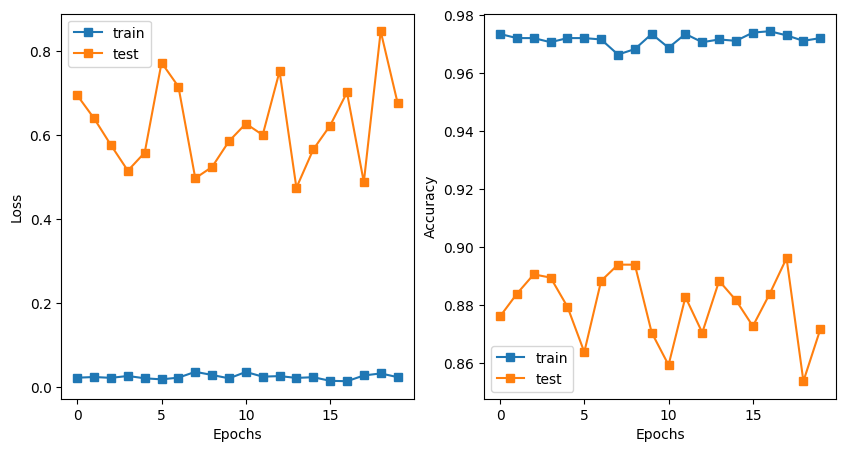

In [ ]:
# Hyperparameters
from argparse import Namespace
args = Namespace(batchsize=64, epochs=20, lr=0.001, neurons=100, eval=False,f=False)

# # Your code to define loss function and optimizer here. Aim for 2 lines.
# loss = torch.nn.CrossEntropyLoss()
# train(X_trn, y_trn, plain_cnn_model, loss, args)
# orion_train()
plot_epochs(X_trn, y_trn, X_tst, y_tst, plain_cnn_model.to(device), args)


# 3.1 ResNet

In [ ]:
import torch
resnet18_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True);
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet18_model.eval();

with np.load(path_for_npz) as data:
  X = data['X'];
  print(X.shape);
  #X = X[:,:,:,2]; # Get one channel
  X = X.reshape(-1, 3, 120, 120);
  print('X.shape', X.shape);

  X_new = preprocess_image(X);


  X = X / 255.0; #Normalize data

  X_trn, X_tst, y_trn, y_tst = split_data();

loss = torch.nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(plain_cnn_model.parameters(), lr=lr);
plot_epochs(X_trn, y_trn, X_tst, y_tst, resnet18_model, optimizer);

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


(2952, 120, 120, 3)
X.shape (2952, 3, 120, 120)


TypeError: ignored

In [ ]:
# Your mini-batch training loop here. Aim for 9-12 lines.
next_epoch = 1
for epoch in range(next_epoch, next_epoch+num_epoch):
    
    # Make an entire pass (an 'epoch') over the training data in batch_size chunks
    for i in range(0, len(X_trn), batch_size):        
        X = X_trn[i:i+batch_size]     # Slice out a mini-batch of features
        y = y_trn[i:i+batch_size]     # Slice out a mini-batch of targets

        y_pred = model(X)
        l = loss(y_pred, y)                 # Compute loss with respect to predictions

        model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
        l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
        optimizer.step()                    # Use the gradients to take a step with SGD.
        
    print("Epoch %2d: final minibatch had loss: %.4f" % (epoch, l.item()))
    
print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst), y_tst)))
# print("Train Score", model.score(X_trn, y_trn))
# print("Test Score", model.score(X_tst, y_tst))

In [ ]:
# Your code here. Aim for 2-3 lines. Re-use the y_true matrix from the earlier code cell.
y_pred_soft = torch.softmax(model(X_trn[:50]), dim=1)
plot_named_tensors({'$\hat{y}$': y_pred_soft[:50], '$y$': y_true})

In [ ]:
# You code here. Aim for 1-4 lines.
plot_matrix_grid(X_trn[:,:].reshape(-1,120,120))

**Inspect your trained model's filters** by plotting them with the *plot_matrix_grid* function. They should no longer be completely random and instead contain structures that look like little "edge" detectors, such as the "diagonal line" detector shown below
![image](img/mnist_trained_filters.png)

In [ ]:
# Your code here. Aim for 2-3 lines.
W1, _, _, _, _, _ = model.parameters()
plot_matrix_grid(W1.squeeze(1))